In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
import torch
import math
import re
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from tokenizers import ByteLevelBPETokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\satvm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv("poetry.csv")

In [3]:
df = df.iloc[:len(df)]

In [4]:
pd.set_option('display.max_colwidth', None)
df.tail()

,Unnamed: 0,Title,Poem,Poet,Tags
13849,13,\r\r\n 1-800-FEAR\r\r\n,\r\r\nWe'd like to talk with you about fear they said so\r\r\r\nmany people live in fear these days they drove up\r\r\r\nall four of them in a small car nice boy they said\r\r\r\nbeautiful dogs they said so friendly the man ahead\r\r\r\nof the woman the other two waiting in the drive I\r\r\r\nwas outside digging up the garden no one home I said\r\r\r\nwhat are you selling anyway I'm not interested I\r\r\r\nsaid well you have a nice day they said here's our\r\r\r\ncard there's a phone number you can call anytime\r\r\r\nany other houses down this road anyone else live\r\r\r\nhere we'd like to talk to them about living in fear\r\r\n,Jody Gladding,"Living,Social Commentaries,Popular Culture"
13850,14,\r\r\n The Death of Atahuallpa\r\r\n,\r\r\n\r\r\n,William Jay Smith,NaN
13851,15,\r\r\n Poet's Wish\r\r\n,\r\r\n\r\r\n,William Jay Smith,NaN
13852,0,\r\r\n 0\r\r\n,"\r\r\n Philosophic\r\r\nin its complex, ovoid emptiness,\r\r\na skillful pundit coined it as a sort\r\r\n of stopgap doorstop for those\r\r\n quaint equations Romans never\r\r\ndreamt of. In form completely clever\r\r\nand discrete—a mirror come unsilvered, loose watch face without the works, a hollowed globe from tip to toe\r\r\nunbroken, it evades the grappling\r\r\nhooks of mass, tilts the thin rim of no thing, remains embryonic sum, non-cogito.\r\r\n",Hailey Leithauser,"Arts & Sciences,Philosophy"
13853,1,\r\r\n !\r\r\n,"\r\r\nDear Writers, I’m compiling the first in what I hope is a series of publications I’m calling artists among artists. The theme for issue 1 is “Faggot Dinosaur.” I hope to hear from you! Thank you and best wishes.",Wendy Videlock,"Relationships,Gay, Lesbian, Queer,Arts & Sciences,Poetry & Poets,Social Commentaries,Gender & Sexuality"


In [5]:
df.isna().sum()

Unnamed: 0      0
Title           0
Poem            0
Poet            0
Tags          955
dtype: int64

In [6]:
df = df.drop(['Unnamed: 0', 'Tags', 'Poet', 'Title'], axis=1)

In [7]:
# df['Title'] = df['Title'].str.replace('\r', '')
df['Poem'] = df['Poem'].str.replace('\r', '')
# df['Title'] = df['Title'].str.replace('\n', '')
df['Poem'] = df['Poem'].str.strip('\n')

In [8]:
df.tail()

,Poem
13849,We'd like to talk with you about fear they said so\nmany people live in fear these days they drove up\nall four of them in a small car nice boy they said\nbeautiful dogs they said so friendly the man ahead\nof the woman the other two waiting in the drive I\nwas outside digging up the garden no one home I said\nwhat are you selling anyway I'm not interested I\nsaid well you have a nice day they said here's our\ncard there's a phone number you can call anytime\nany other houses down this road anyone else live\nhere we'd like to talk to them about living in fear
13850,
13851,
13852,"Philosophic\nin its complex, ovoid emptiness,\na skillful pundit coined it as a sort\n of stopgap doorstop for those\n quaint equations Romans never\ndreamt of. In form completely clever\nand discrete—a mirror come unsilvered, loose watch face without the works, a hollowed globe from tip to toe\nunbroken, it evades the grappling\nhooks of mass, tilts the thin rim of no thing, remains embryonic sum, non-cogito."
13853,"Dear Writers, I’m compiling the first in what I hope is a series of publications I’m calling artists among artists. The theme for issue 1 is “Faggot Dinosaur.” I hope to hear from you! Thank you and best wishes."


In [9]:
# Lower case everything
# df['Title'] = df['Title'].str.lower()
df['Poem'] = df['Poem'].str.lower()

# Remove apostrophes and join the parts
# df['Title'] = df['Title'].str.replace("'", "", regex=False).str.replace("’", "", regex=False)
df['Poem'] = df['Poem'].str.replace("'", "", regex=False).str.replace("’", "", regex=False)

In [10]:
# Uncomment only when including encoder, until then let it be commented off
# Filter out rows where both 'Title' and 'Poem' have no alphabetic characters

# df = df[df.apply(lambda x: any(c.isalpha() for c in x['Title']) and
#                             any(c.isalpha() for c in x['Poem']), axis=1)]

# Filter out rows with no value (its not NaN its '' in this dataset)
df = df[df.apply(lambda x: any(c.isalpha() for c in x['Poem']), axis=1)]

In [11]:
# Make newline a special token
# df['Title'] = 'START ' + df['Title'] + ' END'
df['Poem'] = 'START ' + df['Poem'] + ' END'

df['Poem'] = df['Poem'].apply(lambda x: re.sub(r'\n', ' N ', x))

In [12]:
def remove_numeric_tokens(text):
    tokens = word_tokenize(text)
    # Filter tokens to exclude any that contain digits
    filtered_tokens = [token for token in tokens if not re.search(r'\d', token)]
    processed_text = ' '.join(filtered_tokens)
    return processed_text

df['Poem'] = df['Poem'].apply(remove_numeric_tokens)

In [13]:
df.tail()

,Poem
13835,"START dear writers , im compiling the first in what i hope is a series of publications im calling artists among artists . the theme for issue is “ faggot dinosaur. ” i hope to hear from you ! thank you and best wishes . END"
13848,"START the wise men will unlearn your name . N above your head no star will flame . N one weary sound will be the same— N the hoarse roar of the gale . N the shadows fall from your tired eyes N as your lone bedside candle dies , N for here the calendar breeds nights N till stores of candles fail . N what prompts this melancholy key ? N a long familiar melody . N it sounds again . so let it be . N let it sound from this night . N let it sound in my hour of death— N as gratefulness of eyes and lips N for that which sometimes makes us lift N our gaze to the far sky . N you glare in silence at the wall . N your stocking gapes : no gifts at all . N its clear that you are now too old N to trust in good saint nick ; N that its too late for miracles . N —but suddenly , lifting your eyes N to heavens light , you realize : N your life is a sheer gift . END"
13849,START wed like to talk with you about fear they said so N many people live in fear these days they drove up N all four of them in a small car nice boy they said N beautiful dogs they said so friendly the man ahead N of the woman the other two waiting in the drive i N was outside digging up the garden no one home i said N what are you selling anyway im not interested i N said well you have a nice day they said heres our N card theres a phone number you can call anytime N any other houses down this road anyone else live N here wed like to talk to them about living in fear END
13852,"START philosophic N in its complex , ovoid emptiness , N a skillful pundit coined it as a sort N of stopgap doorstop for those N quaint equations romans never N dreamt of . in form completely clever N and discrete—a mirror come unsilvered , loose watch face without the works , a hollowed globe from tip to toe N unbroken , it evades the grappling N hooks of mass , tilts the thin rim of no thing , remains embryonic sum , non-cogito . END"
13853,"START dear writers , im compiling the first in what i hope is a series of publications im calling artists among artists . the theme for issue is “ faggot dinosaur. ” i hope to hear from you ! thank you and best wishes . END"


In [14]:
df.isna().sum()

Poem    0
dtype: int64

In [15]:
df.size

13751

In [17]:
tokenizer = ByteLevelBPETokenizer()

# Saving poems to a file (required for tokenizer training)
poem_file = "poems.txt"
with open(poem_file, "w", encoding='utf-8') as file: 
    file.write(' N '.join(df['Poem']))

# Train the tokenizer on the poems
tokenizer.train(files=[poem_file], vocab_size=32000, min_frequency=1, special_tokens=["START", "END", "N", "UNK", "PAD"])

In [33]:
vocab_size = tokenizer.get_vocab_size()  # Number of unique words in the vocabulary
embedding_dim = 256
batch_size = 16 # Increase batch size if resources allow as it bring stabilization, 1 is very noisy
learning_rate = 0.001 # changed lr because maybe the embedding dim is too low and lr is too high so gradient is just bouncing around and not learning much
heads = 4
epochs = 10
seq_len = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
with open(poem_file, "r", encoding='utf-8') as file: 
    f = file.read()
    
data = torch.tensor(tokenizer.encode(f).ids)

In [34]:
def preprocessing(data, seq_len, pad_token):
    input_tensor = []
    target_tensor = []
    i = 0

    while i < len(data):
        input_tensor.append(torch.tensor(data[i:i+seq_len]))
        target_tensor.append(torch.tensor(data[i+1:i+seq_len+1]))
        i += seq_len
    
    input_tensor = torch.nn.utils.rnn.pad_sequence(input_tensor, padding_value=pad_token, batch_first=True)
    target_tensor = torch.nn.utils.rnn.pad_sequence(target_tensor, padding_value=pad_token, batch_first=True)
    
    return input_tensor, target_tensor

pad_token = tokenizer.token_to_id("PAD")         
input_tensor, target_tensor = preprocessing(data, seq_len, pad_token)

C:\Users\satvm\AppData\Local\Temp\ipykernel_30740\3625983418.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor.append(torch.tensor(data[i:i+seq_len]))
C:\Users\satvm\AppData\Local\Temp\ipykernel_30740\3625983418.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor.append(torch.tensor(data[i+1:i+seq_len+1]))


In [35]:
input_tensor.shape

torch.Size([25359, 200])

In [36]:
target_tensor.shape

torch.Size([25359, 200])

In [37]:
input_tensor[51]

tensor([  267,   720,  1477,    87,   346,   262,  1411,   288,  7504,   266,
        28966,   266,   285,  4185,  2312,   224,     2,   267,  1574,   292,
         5193,  4386,   288,   437,  6180,  1834,  1378,   359,  2812,   436,
          502,  3203,   224,     2,   294,   526,   364,  1236,   267,  1625,
          720,  1477,    87, 15588,  1211, 27471,   285,  1094,  4946,   224,
            2,   674,   267, 27339, 28232,  2845,   286,   266,   285,   267,
         5812,  1236,  3636,  1316, 14592,  1164,   224,     2,   585,   347,
          720,   345,   267, 27664,   288,  2278,  5582,   266,   267,   691,
           17,  1786,  1120,  1516,   224,     2,   288,  1292,  3635,  1363,
         3314,  2361,   266,   285,   267,  1634,   288,   267,  3768,   488,
          365,   950,    92,   224,     2,   274,  3524,   436,   414,  1316,
          373,   702,   224,     2,   224,     1,   224,     2,   224,     0,
          267,   768,  1720,   274,   530,  1852,   224,     2, 

In [38]:
target_tensor[51]

tensor([  720,  1477,    87,   346,   262,  1411,   288,  7504,   266, 28966,
          266,   285,  4185,  2312,   224,     2,   267,  1574,   292,  5193,
         4386,   288,   437,  6180,  1834,  1378,   359,  2812,   436,   502,
         3203,   224,     2,   294,   526,   364,  1236,   267,  1625,   720,
         1477,    87, 15588,  1211, 27471,   285,  1094,  4946,   224,     2,
          674,   267, 27339, 28232,  2845,   286,   266,   285,   267,  5812,
         1236,  3636,  1316, 14592,  1164,   224,     2,   585,   347,   720,
          345,   267, 27664,   288,  2278,  5582,   266,   267,   691,    17,
         1786,  1120,  1516,   224,     2,   288,  1292,  3635,  1363,  3314,
         2361,   266,   285,   267,  1634,   288,   267,  3768,   488,   365,
          950,    92,   224,     2,   274,  3524,   436,   414,  1316,   373,
          702,   224,     2,   224,     1,   224,     2,   224,     0,   267,
          768,  1720,   274,   530,  1852,   224,     2,   346, 

In [39]:
dataset = TensorDataset(input_tensor, target_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [26]:
n_batches = 0
for i in data_loader:
    n_batches+=1
    
print("Number of batches: ",n_batches)

Number of batches:  860


In [27]:
pad_token

4

In [28]:
class WordEmbedder(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

    def forward(self, x):
        return self.embeddings(x)

In [29]:
# Now that we have successfully trained our word embedding layer, time to make our positional matrix, which we will make using the formula mentioned in the paper
def positional_encoding(seq_len, embedding_dim, device=device):
        positional_encoding = torch.zeros(seq_len, embedding_dim)
        position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embedding_dim))
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding

In [30]:
# Time to make the Multi-head Self Attention block
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, heads, embedding_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.heads = heads

        # 3 Linear Layers for Q, K and V
        self.w_q = nn.Linear(embedding_dim, embedding_dim)
        self.w_k = nn.Linear(embedding_dim, embedding_dim)
        self.w_v = nn.Linear(embedding_dim, embedding_dim)

        # Since the feature or embedding dimension is typically the last dimension
        self.softmax = nn.Softmax(dim=-1)

        # Last Linear layer for the attention
        self.w_a = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, embedding_vector):
        batch_size, seq_len, embedding_dim = embedding_vector.size()
        # Compute Q, K, and V
        Q = self.w_q(embedding_vector)
        K = self.w_k(embedding_vector)
        V = self.w_v(embedding_vector)

        # Seperate into heads
        head_dim = embedding_dim // self.heads
        Q = Q.view(batch_size, self.heads, seq_len, head_dim)
        K = K.view(batch_size, self.heads, seq_len, head_dim)
        V = V.view(batch_size, self.heads, seq_len, head_dim)

        # Calculate attention
        attention = torch.matmul(self.softmax(torch.matmul(Q, K.transpose(-1, -2)) / torch.sqrt(torch.tensor(embedding_dim))), V)

        # Concatenating the attention heads (Transposing for correct concatenation)
        attention = attention.transpose(1, 2).reshape(batch_size, seq_len, embedding_dim)
        output = self.w_a(attention)
        # print("Shape after attention:", output.shape)
        # num_active_elements = torch.gt(output, -1).sum().item()
        # total_elements = output.numel()
        # print(f"active  att: {num_active_elements}/{total_elements}")
        return output

In [31]:
# Time to make the Masked Multi-head Self Attention block
class MaskedMultiHeadSelfAttention(nn.Module):
    def __init__(self, heads, embedding_dim):
        super(MaskedMultiHeadSelfAttention, self).__init__()
        self.heads = heads

        # 3 Linear Layers for Q, K and V
        self.w_q = nn.Linear(embedding_dim, embedding_dim)
        self.w_k = nn.Linear(embedding_dim, embedding_dim)
        self.w_v = nn.Linear(embedding_dim, embedding_dim)

        # Since the feature or embedding dimension is typically the last dimension
        self.softmax = nn.Softmax(dim=-1)

        # Last Linear layer for the attention
        self.w_a = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, embedding_vector):
        batch_size, seq_len, embedding_dim = embedding_vector.size()
        # Compute Q, K, and V
        Q = self.w_q(embedding_vector)
        K = self.w_k(embedding_vector)
        V = self.w_v(embedding_vector)

        # Seperate into heads
        head_dim = embedding_dim // self.heads
        Q = Q.view(batch_size, self.heads, seq_len, head_dim)
        K = K.view(batch_size, self.heads, seq_len, head_dim)
        V = V.view(batch_size, self.heads, seq_len, head_dim)

        # Create a mask for masking the attention score
        mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool), diagonal=1).unsqueeze(0).unsqueeze(0).expand(batch_size, self.heads, -1, -1).to(device)
        value_to_fill = float('-inf')

        # Calculate attention (including mask)
        attention = torch.matmul(self.softmax(torch.matmul(Q, K.transpose(-1, -2)).masked_fill(mask, value_to_fill) / torch.sqrt(torch.tensor(embedding_dim))), V)
        # Concatenating the attention heads (Transposing for correct concatenation)
        attention = attention.transpose(1, 2).reshape(batch_size, seq_len, embedding_dim)
        output = self.w_a(attention)
        # print("Shape after mask:", output.shape)
        # num_active_elements = torch.gt(output, -1).sum().item()
        # total_elements = output.numel()
        # print(f"active masked: {num_active_elements}/{total_elements}")
        return output

In [32]:
class AddNorm(nn.Module):
    def __init__(self, n_features):
        super(AddNorm, self).__init__()
        # Layer Norm will normalize the last dimension of the matrix
        self.norm = nn.LayerNorm(n_features)

    def forward(self, original, modified):
        return self.norm(original + modified)

In [33]:
class FeedForward(nn.Module):
    def __init__(self, embedding_dim):
        super(FeedForward, self).__init__()
        # Normally nn.Linear(embedding_dim, embedding_dim * 4) for expressiveness, we will change it if we have the resources to do so
        self.lr1 = nn.Linear(embedding_dim, embedding_dim)
        self.relu = nn.ReLU()
        self.lr2 = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x):
        x = self.lr1(x)
        x = self.relu(x)
        x = self.lr2(x)
        # num_active_elements = torch.gt(x, -1).sum().item()
        # total_elements = x.numel()
        # print(f"active feedforward: {num_active_elements}/{total_elements}")
        return x

In [45]:
# Time to build the Decoder
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, batch_size, max_length, heads):
        super(Decoder, self).__init__()
        self.word_embedder = WordEmbedder(vocab_size, embedding_dim)
        self.masked_attention = MaskedMultiHeadSelfAttention(heads, embedding_dim)
        self.add_norm1 = AddNorm(embedding_dim)
        self.attention = MultiHeadSelfAttention(heads, embedding_dim)
        self.add_norm2 = AddNorm(embedding_dim)
        self.feed_forward = FeedForward(embedding_dim)
        self.add_norm3 = AddNorm(embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        # print("Shape before word embedder:", x.shape)
        x = self.word_embedder(x)
        # print("Shape after word embedder/before positional:", x.shape)
        # num_active_elements = torch.gt(x, -1).sum().item()
        # total_elements = x.numel()
        # print(f"active word embedder: {num_active_elements}/{total_elements}")
        x += positional_encoding(x.size(1), embedding_dim).unsqueeze(0).expand(x.size(0), -1, -1).to(device)
        # print("Shape after positional:", x.shape)
        # num_active_elements = torch.gt(x, -1).sum().item()
        # total_elements = x.numel()
        # print(f"active positional_encoding: {num_active_elements}/{total_elements}")
#         print(x.shape)
        x = self.add_norm1(x, self.masked_attention(x))
        # print("Shape after addnorm1:", x.shape)
        # num_active_elements = torch.gt(x, -1).sum().item()
        # total_elements = x.numel()
        # print(f"active add_norm1: {num_active_elements}/{total_elements}")
#         print(x.shape)
        x = self.add_norm2(x, self.attention(x))
        # print("Shape after addnorm2:", x.shape)
        # num_active_elements = torch.gt(x, -1).sum().item()
        # total_elements = x.numel()
        # print(f"active add_nor2: {num_active_elements}/{total_elements}")
#         print(x.shape)
        x = self.add_norm3(x, self.feed_forward(x))
        # print("Shape after addnorm3:", x.shape)
        # num_active_elements = torch.gt(x, -1).sum().item()
        # total_elements = x.numel()
        # print(f"active add_norm3: {num_active_elements}/{total_elements}")
#         print(x.shape)
        # print("Shape before linear:", x.shape)
        logits = self.linear(x)
        # print("Shape after linear:", logits.shape)
        # num_active_elements = torch.gt(logits, 0).sum().item()
        # total_elements = logits.numel()
        # print(f"active linear: {num_active_elements}/{total_elements}")
        # print(logits.shape)
        return F.softmax(logits)

In [46]:
model = Decoder(vocab_size, embedding_dim, batch_size, max_length, heads).to(device)

In [47]:
# Initialize our optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token)

In [48]:
def train_epoch(data_loader, model, optimizer, loss_fn, device, pad_token):
    model.train()
    total_loss = 0.0

    # Wrap your data loader with tqdm for a progress bar
    progress_bar = tqdm(data_loader, desc="Training", leave=True)

    for input_batch, target_batch in progress_bar:
        input_data = input_batch.to(device)  
        target_data = target_batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        probs = model(input_data)
        
        # Reshape input and output to correct format for loss calculation
        B, T, C = probs.shape
        probs = probs.view(B*T, C)
        target_data = target_data.view(-1)
        
        # Calculate loss
        loss = loss_fn(probs, target_data)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Update the progress bar with the current batch loss
        progress_bar.set_postfix(loss=loss.item())

    average_loss = total_loss / len(data_loader)
    return average_loss

epoch_losses = []
for epoch in range(epochs):
    print(f"Starting Epoch {epoch + 1}/{epochs}")
    epoch_loss = train_epoch(data_loader, model, optimizer, loss_fn, device, pad_token)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.15f}")

Starting Epoch 1/10


Training:   0%|                                                                                | 0/860 [00:00<?, ?it/s]C:\Users\satvm\AppData\Local\Temp\ipykernel_25864\2976947391.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(logits)
Training:  62%|████████████████████████████████████▎                      | 530/860 [01:24<00:52,  6.25it/s, loss=8.51]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (2,)

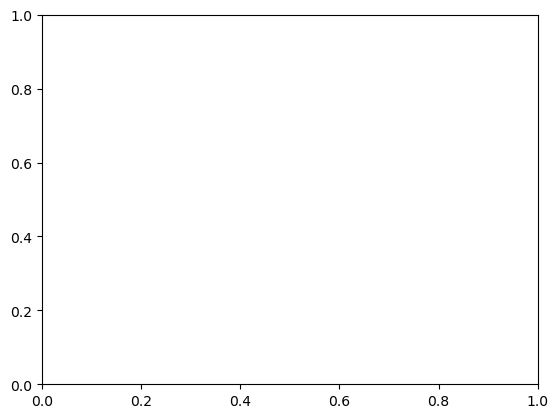

In [38]:
plt.plot(range(1, epochs + 1), epoch_losses) 
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Over Epochs")
plt.show()

In [ ]:
model_path = "model_weights.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load("model_weights.pth"))
model.eval()

In [39]:
def generate_poem(model, start_sequence, tokenizer=tokenizer, max_length=200, pad_token=pad_token):
  model.eval()  # Set the model to evaluation mode.
  tokens = tokenizer.encode(start_sequence)  # Encode the start sequence to tokens directly using the tokenizer.

  # Check if padding token is provided
  if pad_token is None:
    raise ValueError("Padding token (pad_token) argument is required for generation with padding.")

  # Initialize the sequence with the token IDs of the start sequence
  generated_ids = tokens.ids

  # Add padding to reach the desired max_length
  padding_length = max_length - len(generated_ids)
  generated_ids += [pad_token] * padding_length

  # Convert to tensor and move to device
  input_seq = torch.tensor([generated_ids], dtype=torch.long).to(device)

  # Generate tokens using greedy decoding with padding
  for _ in range(max_length):
    with torch.no_grad():
      output_logits = model(input_seq)

    next_token_id = output_logits[:, -1, :].argmax(-1).item()

    # Stop if the end token or padding token is generated.
    if next_token_id == tokenizer.token_to_id("END") or next_token_id == pad_token:
      break

    generated_ids.append(next_token_id)
    # Truncate the sequence to remove padding tokens during decoding
    input_seq = input_seq[:, :-1]  # Remove last element (padding)
    input_seq = torch.cat((input_seq, torch.tensor([[next_token_id]], dtype=torch.long).to(device)), dim=1)

  # Decode the token IDs back to text using the tokenizer, removing padding tokens
  generated_text = tokenizer.decode(generated_ids[: len(tokens) + 1], skip_special_tokens=True)  # Remove start and padding tokens

  return generated_text

In [40]:
start_sequence = "the tree"
poem = generate_poem(model, start_sequence)
print(poem)

the tree
